In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("Restaurant_Train.xlsx")
df.sample(5)

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
10046,QUICK BITES,358,"South Indian, Chinese, Arabian, Kerala","Closed (Mon),8:57am – 12midnight (Tue),8:15am ...",Kochi,Tripunithura,3.3,32 votes,200
9248,QUICK BITES,6021,South Indian,"7:30am – 12:45pm, 3:45pm – 8:45pm (Mon, Tue...",Bangalore,Malleshwaram,4.2,752 votes,150
4468,QUICK BITES,11716,"North Indian, Chinese",11am – 11pm (Mon-Sun),Navi Mumbai,Ulwe,NEW,NaN,400
4493,CASUAL DINING,12892,"North Indian, South Indian","12noon – 3:30pm, 7pm – 11pm (Mon-Sun)",Bengalore,Jayanagar,4.2,2049 votes,1000
10845,QUICK BITES,10033,"Fast Food, Continental","11am – 11pm (Mon-Sat),12noon – 11pm (Sun)",GST Road,Urapakkam Station Road,3.5,28 votes,300


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TITLE          12690 non-null  object
 1   RESTAURANT_ID  12690 non-null  int64 
 2   CUISINES       12690 non-null  object
 3   TIME           12690 non-null  object
 4   CITY           12578 non-null  object
 5   LOCALITY       12592 non-null  object
 6   RATING         12688 non-null  object
 7   VOTES          11486 non-null  object
 8   COST           12690 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 892.4+ KB


Most number of missing values VOTES(1204), followed by CITY(112), LOCALITY(98), RATING(2)

7 categorical columns and only 2 numerical column one of the being our target column COST.

RESTAURANT_ID can be dropped since we can make use of Index for our purpose which would left us with only target column as numeric variable.

In [4]:
df.drop("RESTAURANT_ID",1,inplace=True)

In [5]:
df.describe()

,COST
count,12690.000000
mean,655.252246
std,627.003540
min,20.000000
25%,300.000000
50%,500.000000
75%,800.000000
max,14000.000000


max value is way above the 75 percentile, we can assume there are lots of outliers.

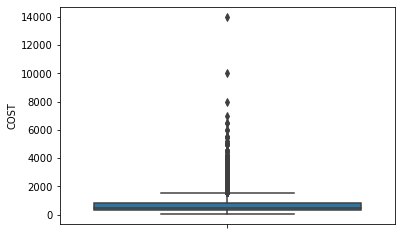

In [6]:
sns.boxplot(df['COST'], orient="v")
plt.show()

There are quite a large number of outliers.

In [7]:
#Checking number of unique values in every column

for i in df.columns:
    print("Number of unique values in {} is:".format(i),len(df[i].unique()))

Number of unique values in TITLE is: 113
Number of unique values in CUISINES is: 4155
Number of unique values in TIME is: 2689
Number of unique values in CITY is: 360
Number of unique values in LOCALITY is: 1417
Number of unique values in RATING is: 33
Number of unique values in VOTES is: 1848
Number of unique values in COST is: 86


Since there are not so many unique COST values so we can treat its outliers to make our model efficient.

We shall drop Title and TIME as well as it shouldn't matter much in COST.

We can drop CITY as LOCALITY gives mode vivid data on locality.

CUISINES play a big role in pricing of the dish, Locality plays an important role too, as restaurants in posh areas will have higher price, more rating means preference, rating also depends on number of votings, as average vote rate is the rating.

In [8]:
df.drop(['TITLE', 'TIME', 'CITY'],1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CUISINES  12690 non-null  object
 1   LOCALITY  12592 non-null  object
 2   RATING    12688 non-null  object
 3   VOTES     11486 non-null  object
 4   COST      12690 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 495.8+ KB


We need to encode now as we can't do analysis on categorical data. But first let's clean the dataset.

In [10]:
df['RATING'].value_counts()

3.9    1238
3.8    1190
4.0    1099
3.7    1086
3.6     951
4.1     936
3.5     771
4.2     723
NEW     707
3.4     575
4.3     556
-       495
3.3     365
4.4     362
3.2     266
4.5     199
2.9     186
3.1     186
3.0     170
2.8     146
4.6     141
2.7      89
4.7      69
2.6      61
2.5      35
4.8      32
4.9      22
2.4      15
2.3      10
2.1       3
2.0       2
2.2       2
Name: RATING, dtype: int64

We have 707 as NEW, 495 as - and 2 blank values.

Let's find out the mean of the present values and put them in the NEW, - and blank values

In [11]:
arr = []
barr = []
for i in list(df['RATING']):
    if i not in ['NEW', '-', '']:
        arr.append(i)
    else:
        barr.append(i)



len(arr)

11488

In [12]:
df_New = pd.DataFrame()
df_New['RATING'] = df['RATING']
#df_New.dropna(inplace=True)
df_New.loc[(df_New['RATING'].isnull()) | (df_New['RATING'] == '-') | (df_New['RATING'] == 'NEW'), 'RATING'].index

Int64Index([   13,    62,    69,    85,   111,   117,   120,   156,   165,
              178,
            ...
            12584, 12585, 12591, 12602, 12613, 12630, 12641, 12646, 12658,
            12660],
           dtype='int64', length=1204)

In [13]:
for i in df_New.loc[(df_New['RATING'].isnull()) | (df_New['RATING'] == '-') | (df_New['RATING'] == 'NEW'), 'RATING'].index:
    df_New.drop(i, inplace=True)

In [14]:
#Average of RATINGS in the dataset

df_New['RATING'] = df_New['RATING'].astype('float64')
avg_of_RATING = df_New['RATING'].mean()
avg_of_RATING = round(avg_of_RATING,1)
avg_of_RATING

3.8

In [15]:
#Replace the not RATING value in dataset with the average RATING

df.loc[(df['RATING'].isnull()) | (df['RATING'] == '-') | (df['RATING'] == 'NEW'), 'RATING'] = avg_of_RATING

In [16]:
df['RATING'] = df['RATING'].astype('float64')

In [17]:
df.describe()

,RATING,COST
count,12690.000000,12690.000000
mean,3.786832,655.252246
std,0.401588,627.003540
min,2.000000,20.000000
25%,3.600000,300.000000
50%,3.800000,500.000000
75%,4.000000,800.000000
max,4.900000,14000.000000


In [18]:
from scipy.stats import zscore

In [19]:
df['zcost'] = zscore(df['COST'])
df.skew()

RATING   -0.547569
COST      3.978801
zcost     3.978801
dtype: float64

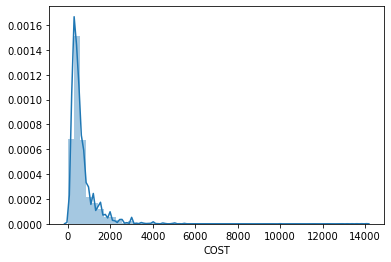

In [20]:
sns.distplot(df['COST'])

COST is highly Positivelly skewed, let's clean the data.

In [21]:
df = df[df['zcost'] < 3]
df.shape

(12466, 6)

224 rows are removed in removal of outliers

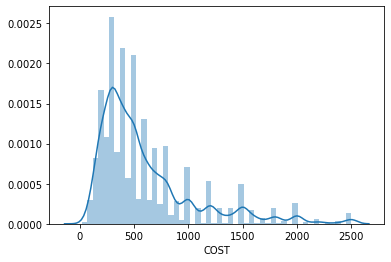

In [22]:
sns.distplot(df['COST'])
plt.show()

In [23]:
df['COST'].skew()

1.7707897187650845

Skewness is well near normal distribution

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12466 entries, 0 to 12689
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CUISINES  12466 non-null  object 
 1   LOCALITY  12369 non-null  object 
 2   RATING    12466 non-null  float64
 3   VOTES     11264 non-null  object 
 4   COST      12466 non-null  int64  
 5   zcost     12466 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 681.7+ KB


In [25]:
for i in df[df['LOCALITY'].isnull()].index:
    df.drop(i, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12369 entries, 0 to 12689
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CUISINES  12369 non-null  object 
 1   LOCALITY  12369 non-null  object 
 2   RATING    12369 non-null  float64
 3   VOTES     11187 non-null  object 
 4   COST      12369 non-null  int64  
 5   zcost     12369 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 676.4+ KB


In [27]:
df['VOTES']

0          49 votes
1          30 votes
2         221 votes
3          24 votes
4         165 votes
            ...    
12685     546 votes
12686    1214 votes
12687     608 votes
12688      32 votes
12689     677 votes
Name: VOTES, Length: 12369, dtype: object

In [28]:
df['VOTES_split'] = df['VOTES'].str.split(" ", n = -1, expand = True)[0]
df['VOTES_split']

0          49
1          30
2         221
3          24
4         165
         ... 
12685     546
12686    1214
12687     608
12688      32
12689     677
Name: VOTES_split, Length: 12369, dtype: object

In [29]:
df['VOTES'] = df['VOTES_split']
df.drop('VOTES_split',1,inplace=True)

In [30]:
df.dtypes

CUISINES     object
LOCALITY     object
RATING      float64
VOTES        object
COST          int64
zcost       float64
dtype: object

In [31]:
df_New = pd.DataFrame()
df_New['VOTES'] = df['VOTES']
arr = df_New.loc[df_New['VOTES'].isnull(), 'VOTES'].index
arr

Int64Index([   13,    62,    69,    85,   111,   117,   120,   156,   165,
              178,
            ...
            12584, 12585, 12591, 12602, 12613, 12630, 12641, 12646, 12658,
            12660],
           dtype='int64', length=1182)

In [32]:
for i in arr:
    df_New.drop(i, inplace=True)

df_New['VOTES'] = df_New['VOTES'].astype('int64')
aoV = round(df_New['VOTES'].mean(),1)
aoV

412.2

In [33]:
df.loc[df['VOTES'].isnull(), 'VOTES'] = aoV

In [34]:
df['VOTES'] = df['VOTES'].astype('int64')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12369 entries, 0 to 12689
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CUISINES  12369 non-null  object 
 1   LOCALITY  12369 non-null  object 
 2   RATING    12369 non-null  float64
 3   VOTES     12369 non-null  int64  
 4   COST      12369 non-null  int64  
 5   zcost     12369 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 676.4+ KB


Data is cleaned, let's Encode the data

In [36]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [37]:
arr = ['CUISINES','LOCALITY']
for i in arr:
    df[i] = le.fit_transform(df[i])

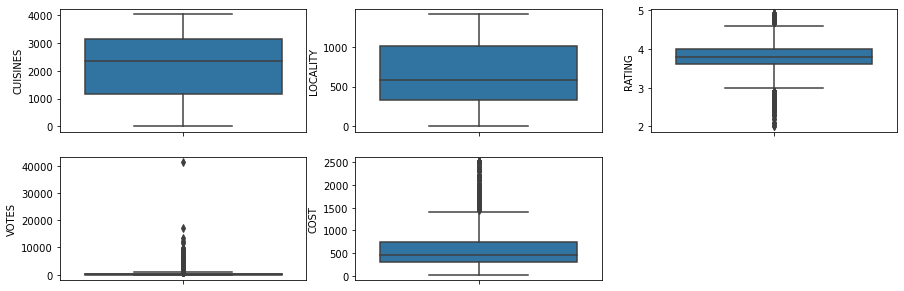

In [38]:
plt.figure(figsize=(15,5))
for i,j in enumerate(df.columns[:-1]):
    plt.subplot(2,3, i+1)
    sns.boxplot(df[j], orient='v')

RATING, VOTE, COST and COST have outliers, VOTES have some outliers which can be removed.

In [39]:
df['zvote'] = zscore(df['VOTES'])
df.skew()

CUISINES    -0.221783
LOCALITY     0.342248
RATING      -0.549645
VOTES       15.032169
COST         1.765018
zcost        1.765018
zvote       15.032169
dtype: float64

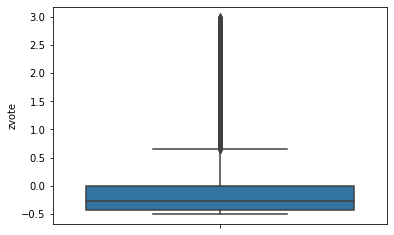

In [40]:
df = df[df['zvote'] < 3]
sns.boxplot(df['zvote'], orient='v')

In [41]:
df.drop(['zcost','zvote'],1,inplace=True)

In [42]:
df.shape

(12173, 5)

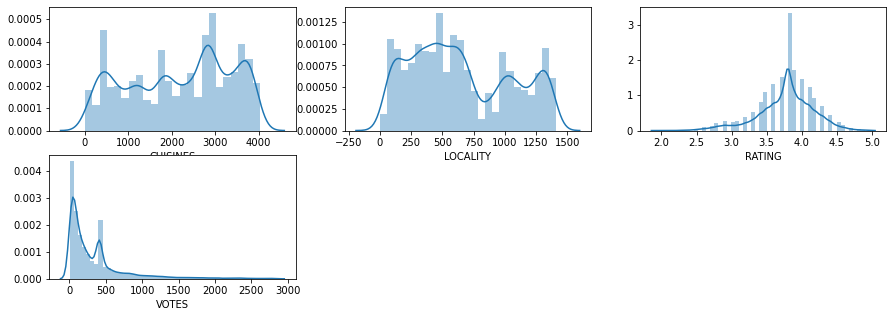

In [43]:
plt.figure(figsize=(15,5))
for i,j in enumerate(df.columns[:-1]):
    plt.subplot(2,3, i+1)
    sns.distplot(df[j])

3.8 rating is the maximum given to the restaurants, it is also the case since we have replaced the missing rating rows with the average which is 3.8, all other columns also seems fine in terms of distribution.

In [44]:
df.skew()

CUISINES   -0.222840
LOCALITY    0.339110
RATING     -0.585640
VOTES       2.534746
COST        1.816192
dtype: float64

<Figure size 1440x432 with 0 Axes>

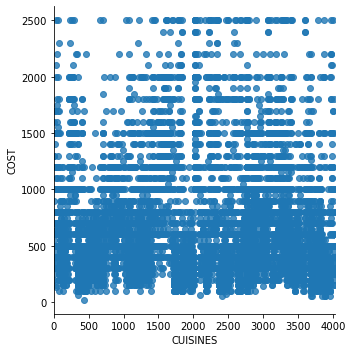

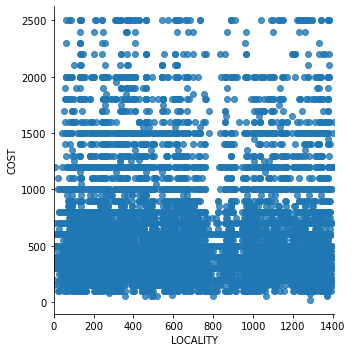

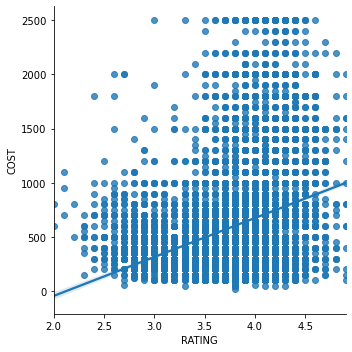

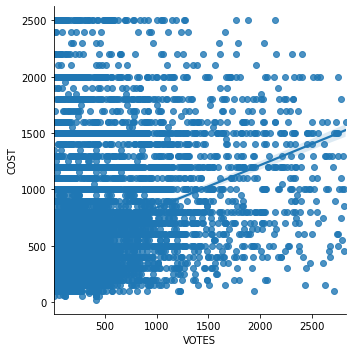

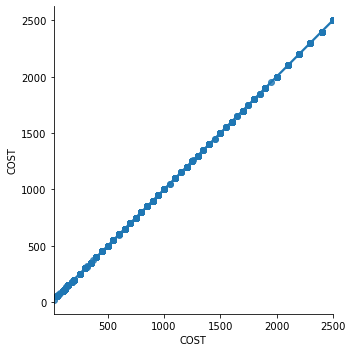

In [45]:
plt.figure(figsize=(20,6))
for i,j in enumerate(df.columns):
    sns.lmplot(x=j, y ='COST', data=df)
plt.show()

Only Rating and Votes columns line are visible and are positive related to the COST.

In [46]:
df.describe()

,CUISINES,LOCALITY,RATING,VOTES,COST
count,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000
mean,2170.039021,650.300501,3.770615,344.501602,591.916619
std,1167.653407,398.045012,0.396228,437.337824,445.781379
min,0.000000,0.000000,2.000000,4.000000,20.000000
25%,1162.000000,333.000000,3.600000,62.000000,300.000000
50%,2361.000000,581.000000,3.800000,189.000000,450.000000
75%,3133.000000,1003.000000,4.000000,412.000000,700.000000
max,4027.000000,1407.000000,4.900000,2825.000000,2500.000000


In [47]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

In [48]:
for i in df.columns:
    if df[i].max() > 100:
        df[i] = mms.fit_transform(df[[i]])

In [49]:
df.describe()

,CUISINES,LOCALITY,RATING,VOTES,COST
count,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000
mean,0.538872,0.462189,3.770615,0.120702,0.230612
std,0.289956,0.282903,0.396228,0.155029,0.179751
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.288552,0.236674,3.600000,0.020560,0.112903
50%,0.586293,0.412935,3.800000,0.065580,0.173387
75%,0.777999,0.712864,4.000000,0.144630,0.274194
max,1.000000,1.000000,4.900000,1.000000,1.000000


In [50]:
#Let's find out the correlation matrix

corr = df.corr()
corr

,CUISINES,LOCALITY,RATING,VOTES,COST
CUISINES,1.000000,0.015704,-0.063241,-0.025141,-0.029814
LOCALITY,0.015704,1.000000,-0.025436,-0.041800,-0.016544
RATING,-0.063241,-0.025436,1.000000,0.432145,0.319969
VOTES,-0.025141,-0.041800,0.432145,1.000000,0.369390
COST,-0.029814,-0.016544,0.319969,0.369390,1.000000


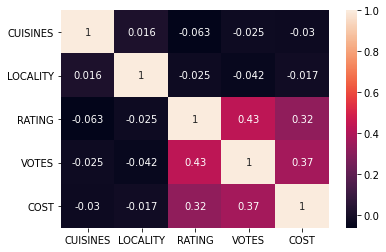

In [51]:
sns.heatmap(corr, annot=True)

In [52]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
X = df.drop("COST",1)
Y = df['COST']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7)

In [53]:
#Models Import
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

#Metrics Import
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [54]:
def classify(model, x, y):
    # Model training
    model.fit(x, y)
    pred = model.predict(x)
    print("MSE is:",mean_squared_error(y,pred))
    #Cross validation
    score = cross_val_score(model, x,y, cv=5)
    print("Cross validation score is :",(np.mean(score)))
    return np.abs(np.mean(score))

In [55]:
#Regression
lm = LinearRegression()
rr = Ridge()
ls = Lasso()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
etr = ExtraTreesRegressor()
gbr = GradientBoostingRegressor()

#Regression Parameters
rrparams = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1.0], 'random_state': range(70,150)}
lsparams = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1.0], 'random_state': range(70,150)}
dtrparams = {'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'], 'min_samples_split' : range(10),
            'random_state' : range(70,150)}
rfrparams = {'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'], 'n_estimators' : range(50,80),
             'random_state' : range(70,150)}
etrparams = {'criterion' : ['mse', 'friedman_mse', 'mae'], 'min_samples_split' : range(10),
            'random_state' : range(70,150)}
gbrparams = {'loss' : ['ls', 'lad', 'huber', 'quantile'], 'n_estimators' : range(50,80),
             'criterion' : ['mse', 'friedman_mse', 'mae'], 'random_state' : range(70,150)}

In [56]:
def rstate(model, X, Y):
    mse = []
    for i in range(1,201):
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3, random_state=i)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        #print(mean_squared_error(y_test, pred))
        #print(np.sqrt(mean_squared_error(y_test, pred)))
        #print(mean_absolute_error(y_test, pred))
        #print(r2_score(y_test, pred))
        mse.append(mean_squared_error(y_test, pred))
    return mse.index(min(mse))+1

In [57]:
lmRS = rstate(lm, X, Y)
print("Linear Model best random state is: ",lmRS)

Linear Model best random state is:  189


In [58]:
model_score_table = pd.DataFrame(columns=['Model Name','Params', 'MSE Score', 'R2 Score'])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3, random_state=lmRS)
lm.fit(X_train, y_train)
pred = lm.predict(X_test)
print(mean_squared_error(y_test, pred))
print(r2_score(y_test, pred))

0.024655548916142963
0.1685875073070211


In [60]:
model_score_table.loc[0] = ["Linear Regression", '', mean_squared_error(y_test, pred), r2_score(y_test, pred)]
model_score_table

,Model Name,Params,MSE Score,R2 Score
0,Linear Regression,,0.024656,0.168588


In [61]:
rrgs = RandomizedSearchCV(rr, rrparams, return_train_score = False, n_iter=100, cv = 5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
rrgs.fit(X, Y)
rrDF = pd.DataFrame(rrgs.cv_results_)
rrDF[['params', 'mean_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False)

,params,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_r2,rank_test_r2
23,"{'random_state': 82, 'alpha': 1.0}",-0.026907,82,0.166374,1
26,"{'random_state': 97, 'alpha': 1.0}",-0.026907,82,0.166374,1
24,"{'random_state': 74, 'alpha': 1.0}",-0.026907,82,0.166374,1
27,"{'random_state': 145, 'alpha': 1.0}",-0.026907,82,0.166374,1
81,"{'random_state': 92, 'alpha': 1.0}",-0.026907,82,0.166374,1
...,...,...,...,...,...
56,"{'random_state': 114, 'alpha': 0.0001}",-0.026907,64,0.166373,83
54,"{'random_state': 81, 'alpha': 0.0001}",-0.026907,64,0.166373,83
45,"{'random_state': 138, 'alpha': 0.0001}",-0.026907,64,0.166373,83
1,"{'random_state': 70, 'alpha': 0.0001}",-0.026907,64,0.166373,83


In [62]:
i = list(rrDF['mean_test_neg_mean_squared_error']).index(rrDF['mean_test_neg_mean_squared_error'].max())
model_score_table.loc[1] = ["Ridge Regressor", rrDF['params'][i], rrDF['mean_test_neg_mean_squared_error'][i], rrDF['mean_test_r2'][i]]
model_score_table

,Model Name,Params,MSE Score,R2 Score
0,Linear Regression,,0.024656,0.168588
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",-0.026907,0.166374


In [63]:
lsgs = RandomizedSearchCV(ls, lsparams,return_train_score = False, n_iter=100, cv = 5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
lsgs.fit(X, Y)
lsDF = pd.DataFrame(lsgs.cv_results_)
lsDF[['params', 'mean_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False)

,params,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_r2,rank_test_r2
24,"{'random_state': 77, 'alpha': 0.0001}",-0.026906,1,0.166406,1
81,"{'random_state': 143, 'alpha': 0.0001}",-0.026906,1,0.166406,1
47,"{'random_state': 138, 'alpha': 0.0001}",-0.026906,1,0.166406,1
55,"{'random_state': 80, 'alpha': 0.0001}",-0.026906,1,0.166406,1
42,"{'random_state': 111, 'alpha': 0.0001}",-0.026906,1,0.166406,1
...,...,...,...,...,...
68,"{'random_state': 144, 'alpha': 0.1}",-0.032324,61,-0.001495,61
70,"{'random_state': 131, 'alpha': 1.0}",-0.032324,61,-0.001495,61
71,"{'random_state': 76, 'alpha': 0.1}",-0.032324,61,-0.001495,61
72,"{'random_state': 149, 'alpha': 0.1}",-0.032324,61,-0.001495,61


In [64]:
i = list(lsDF['mean_test_neg_mean_squared_error']).index(lsDF['mean_test_neg_mean_squared_error'].max())
model_score_table.loc[2] = ["Lasso Regressor", lsDF['params'][i], lsDF['mean_test_neg_mean_squared_error'][i], lsDF['mean_test_r2'][i]]
model_score_table

,Model Name,Params,MSE Score,R2 Score
0,Linear Regression,,0.024656,0.168588
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",-0.026907,0.166374
2,Lasso Regressor,"{'random_state': 132, 'alpha': 0.0001}",-0.026906,0.166406


In [65]:
dtrgs = RandomizedSearchCV(dtr, dtrparams,return_train_score = False, n_iter=100, cv = 5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
dtrgs.fit(X, Y)
dtrDF = pd.DataFrame(dtrgs.cv_results_)
dtrDF[['params', 'mean_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False)

,params,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_r2,rank_test_r2
41,"{'random_state': 143, 'min_samples_split': 9, ...",-0.028089,1,0.128567,1
21,"{'random_state': 138, 'min_samples_split': 9, ...",-0.028128,2,0.127094,2
70,"{'random_state': 92, 'min_samples_split': 9, '...",-0.028136,3,0.127087,3
96,"{'random_state': 121, 'min_samples_split': 9, ...",-0.028140,4,0.126906,4
56,"{'random_state': 135, 'min_samples_split': 9, ...",-0.028177,5,0.125565,5
...,...,...,...,...,...
89,"{'random_state': 138, 'min_samples_split': 0, ...",NaN,71,NaN,71
90,"{'random_state': 107, 'min_samples_split': 0, ...",NaN,73,NaN,73
92,"{'random_state': 138, 'min_samples_split': 1, ...",NaN,74,NaN,74
93,"{'random_state': 117, 'min_samples_split': 7, ...",NaN,75,NaN,75


In [66]:
i = list(dtrDF['mean_test_neg_mean_squared_error']).index(dtrDF['mean_test_neg_mean_squared_error'].max())
model_score_table.loc[3] = ["Decision Tree Regressor", dtrDF['params'][i], dtrDF['mean_test_neg_mean_squared_error'][i], dtrDF['mean_test_r2'][i]]
model_score_table

,Model Name,Params,MSE Score,R2 Score
0,Linear Regression,,0.024656,0.168588
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",-0.026907,0.166374
2,Lasso Regressor,"{'random_state': 132, 'alpha': 0.0001}",-0.026906,0.166406
3,Decision Tree Regressor,"{'random_state': 143, 'min_samples_split': 9, ...",-0.028089,0.128567


In [67]:
rfrgs = RandomizedSearchCV(rfr, rfrparams,return_train_score = False, n_iter=100, cv = 5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
rfrgs.fit(X, Y)
rfrDF = pd.DataFrame(rfrgs.cv_results_)
rfrDF[['params', 'mean_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False)

,params,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_r2,rank_test_r2
2,"{'random_state': 142, 'n_estimators': 78, 'cri...",-0.018798,1,0.417914,1
17,"{'random_state': 132, 'n_estimators': 77, 'cri...",-0.018848,2,0.416525,2
60,"{'random_state': 106, 'n_estimators': 50, 'cri...",-0.018851,3,0.416404,3
39,"{'random_state': 143, 'n_estimators': 73, 'cri...",-0.018853,4,0.416106,4
88,"{'random_state': 125, 'n_estimators': 79, 'cri...",-0.018877,5,0.415585,5
...,...,...,...,...,...
74,"{'random_state': 138, 'n_estimators': 67, 'cri...",NaN,87,NaN,87
78,"{'random_state': 99, 'n_estimators': 78, 'crit...",NaN,85,NaN,85
80,"{'random_state': 130, 'n_estimators': 55, 'cri...",NaN,99,NaN,99
94,"{'random_state': 112, 'n_estimators': 56, 'cri...",NaN,83,NaN,83


In [68]:
i = list(rfrDF['mean_test_neg_mean_squared_error']).index(rfrDF['mean_test_neg_mean_squared_error'].max())
model_score_table.loc[4] = ["Random Forest Regressor", rfrDF['params'][i], rfrDF['mean_test_neg_mean_squared_error'][i], rfrDF['mean_test_r2'][i]]
model_score_table

,Model Name,Params,MSE Score,R2 Score
0,Linear Regression,,0.024656,0.168588
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",-0.026907,0.166374
2,Lasso Regressor,"{'random_state': 132, 'alpha': 0.0001}",-0.026906,0.166406
3,Decision Tree Regressor,"{'random_state': 143, 'min_samples_split': 9, ...",-0.028089,0.128567
4,Random Forest Regressor,"{'random_state': 142, 'n_estimators': 78, 'cri...",-0.018798,0.417914


In [69]:
etrgs = RandomizedSearchCV(etr, etrparams,return_train_score = False, n_iter=100, cv = 5, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
etrgs.fit(X, Y)
etrDF = pd.DataFrame(etrgs.cv_results_)
etrDF[['params', 'mean_test_neg_mean_squared_error', 'rank_test_neg_mean_squared_error', 'mean_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False)

,params,mean_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,mean_test_r2,rank_test_r2
52,"{'random_state': 128, 'min_samples_split': 5, ...",-0.021681,1,0.328533,1
10,"{'random_state': 80, 'min_samples_split': 4, '...",-0.021713,2,0.327516,2
94,"{'random_state': 71, 'min_samples_split': 5, '...",-0.021721,3,0.327397,3
88,"{'random_state': 82, 'min_samples_split': 7, '...",-0.021766,4,0.325990,4
75,"{'random_state': 140, 'min_samples_split': 5, ...",-0.021789,5,0.325483,5
...,...,...,...,...,...
74,"{'random_state': 87, 'min_samples_split': 0, '...",NaN,93,NaN,93
77,"{'random_state': 123, 'min_samples_split': 0, ...",NaN,91,NaN,91
83,"{'random_state': 145, 'min_samples_split': 1, ...",NaN,88,NaN,88
89,"{'random_state': 112, 'min_samples_split': 0, ...",NaN,79,NaN,79


In [70]:
i = list(etrDF['mean_test_neg_mean_squared_error']).index(etrDF['mean_test_neg_mean_squared_error'].max())
model_score_table.loc[5] = ["Extra Trees Regressor", etrDF['params'][i], etrDF['mean_test_neg_mean_squared_error'][i], etrDF['mean_test_r2'][i]]
model_score_table

,Model Name,Params,MSE Score,R2 Score
0,Linear Regression,,0.024656,0.168588
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",-0.026907,0.166374
2,Lasso Regressor,"{'random_state': 132, 'alpha': 0.0001}",-0.026906,0.166406
3,Decision Tree Regressor,"{'random_state': 143, 'min_samples_split': 9, ...",-0.028089,0.128567
4,Random Forest Regressor,"{'random_state': 142, 'n_estimators': 78, 'cri...",-0.018798,0.417914
5,Extra Trees Regressor,"{'random_state': 128, 'min_samples_split': 5, ...",-0.021681,0.328533


In [72]:
model_score_table.sort_values(by="R2 Score", ascending=False)

,Model Name,Params,MSE Score,R2 Score
4,Random Forest Regressor,"{'random_state': 142, 'n_estimators': 78, 'cri...",-0.018798,0.417914
5,Extra Trees Regressor,"{'random_state': 128, 'min_samples_split': 5, ...",-0.021681,0.328533
0,Linear Regression,,0.024656,0.168588
2,Lasso Regressor,"{'random_state': 132, 'alpha': 0.0001}",-0.026906,0.166406
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",-0.026907,0.166374
3,Decision Tree Regressor,"{'random_state': 143, 'min_samples_split': 9, ...",-0.028089,0.128567


In [73]:
model_score_table['MSE Score'] = model_score_table['MSE Score'].abs()

In [74]:
model_score_table.sort_values(by="MSE Score")

,Model Name,Params,MSE Score,R2 Score
4,Random Forest Regressor,"{'random_state': 142, 'n_estimators': 78, 'cri...",0.018798,0.417914
5,Extra Trees Regressor,"{'random_state': 128, 'min_samples_split': 5, ...",0.021681,0.328533
0,Linear Regression,,0.024656,0.168588
2,Lasso Regressor,"{'random_state': 132, 'alpha': 0.0001}",0.026906,0.166406
1,Ridge Regressor,"{'random_state': 74, 'alpha': 0.1}",0.026907,0.166374
3,Decision Tree Regressor,"{'random_state': 143, 'min_samples_split': 9, ...",0.028089,0.128567


Best performing model is Random Forest Regressor

In [75]:
#Parameters of the Random Forest Regression
model_score_table['Params'][4]

{'random_state': 142, 'n_estimators': 78, 'criterion': 'friedman_mse'}

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=142)
rfr_model = RandomForestRegressor(random_state = 142, n_estimators = 78, criterion = 'friedman_mse')
rfr_model.fit(X_train, y_train)
pred = rfr_model.predict(X_test)
pred = pd.DataFrame(pred)
pred

,0
0,0.139526
1,0.378102
2,0.157103
3,0.404725
4,0.157103
...,...
3039,0.311931
3040,0.154260
3041,0.218879
3042,0.439620


In [77]:
rfr_model.score(X_train,y_train)

0.9172641709437224

In [78]:
rfr_model.score(X_test,y_test)

0.4113612195300278

In [79]:
print(mean_squared_error(y_test , pred))
print(mean_absolute_error(y_test , pred))

0.01896638899417086
0.0936181124632661


In [101]:
dftest = pd.read_excel('Restaurant_Test.xlsx')
dftest.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes


In [102]:
dftest.drop(['RESTAURANT_ID','TITLE', 'TIME', 'CITY'],1,inplace=True)

In [103]:
dftest_New = pd.DataFrame()
dftest_New['RATING'] = dftest['RATING']
#dftest_New.dropna(inplace=True)
dftest_New.loc[(dftest_New['RATING'].isnull()) | (dftest_New['RATING'] == '-') | (dftest_New['RATING'] == 'NEW'), 'RATING'].index

Int64Index([   6,   21,   24,   27,   29,   37,   66,   68,   73,   76,
            ...
            4108, 4109, 4168, 4172, 4181, 4183, 4185, 4198, 4223, 4229],
           dtype='int64', length=402)

In [104]:
for i in dftest_New.loc[(dftest_New['RATING'].isnull()) | (dftest_New['RATING'] == '-') | (dftest_New['RATING'] == 'NEW'), 'RATING'].index:
    dftest_New.drop(i, inplace=True)

In [105]:
#Average of RATINGS in the dataset
dftest_New['RATING'] = dftest_New['RATING'].astype('float64')
avg_of_RATING = dftest_New['RATING'].mean()
avg_of_RATING = round(avg_of_RATING,1)
avg_of_RATING

3.8

In [106]:
#Replace the not RATING value in dataset with the average RATING
dftest.loc[(dftest['RATING'].isnull()) | (dftest['RATING'] == '-') | (dftest['RATING'] == 'NEW'), 'RATING'] = avg_of_RATING
dftest['RATING'] = dftest['RATING'].astype('float64')

In [107]:
for i in dftest[dftest['LOCALITY'].isnull()].index:
    dftest.drop(i, inplace=True)

In [108]:
dftest['VOTES_split'] = dftest['VOTES'].str.split(" ", n = -1, expand = True)[0]
dftest['VOTES_split']

0        564
1         61
2        350
3       1445
4         23
        ... 
4226     287
4227     469
4228      53
4229     NaN
4230      63
Name: VOTES_split, Length: 4201, dtype: object

In [109]:
dftest['VOTES'] = dftest['VOTES_split']
dftest.drop('VOTES_split',1,inplace=True)

In [110]:
dftest_New = pd.DataFrame()
dftest_New['VOTES'] = dftest['VOTES']
arr = dftest_New.loc[dftest_New['VOTES'].isnull(), 'VOTES'].index
arr

Int64Index([   6,   21,   24,   27,   29,   37,   66,   68,   73,   76,
            ...
            4108, 4109, 4168, 4172, 4181, 4183, 4185, 4198, 4223, 4229],
           dtype='int64', length=399)

In [111]:
for i in arr:
    dftest_New.drop(i, inplace=True)

In [112]:
dftest_New['VOTES'] = dftest_New['VOTES'].astype('int64')
aoV = round(dftest_New['VOTES'].mean(),1)
aoV

431.3

In [113]:
dftest.loc[dftest['VOTES'].isnull(), 'VOTES'] = aoV
dftest['VOTES'] = dftest['VOTES'].astype('int64')

In [114]:
arr = ['CUISINES','LOCALITY']
for i in arr:
    dftest[i] = le.fit_transform(dftest[i])

In [115]:
dftest['zvote'] = zscore(dftest['VOTES'])

In [116]:
dftest = dftest[dftest['zvote'] < 3]

In [117]:
dftest.drop(['zvote'],1,inplace=True)

In [118]:
for i in dftest.columns:
    if dftest[i].max() > 100:
        dftest[i] = mms.fit_transform(dftest[[i]])

In [119]:
import joblib

In [120]:
# save the model to disk
filename = 'final_model.pkl'
joblib.dump(rfr_model, filename)

['final_model.pkl']

In [121]:
dftest.describe()

,CUISINES,LOCALITY,RATING,VOTES
count,4129.000000,4129.000000,4129.000000,4129.000000
mean,0.537573,0.460975,3.772221,0.125352
std,0.288454,0.283004,0.406573,0.156074
min,0.000000,0.000000,2.100000,0.000000
25%,0.280794,0.230492,3.600000,0.022135
50%,0.582604,0.426170,3.800000,0.072831
75%,0.762405,0.698679,4.000000,0.152803
max,1.000000,1.000000,4.900000,1.000000


In [122]:
# load the model from disk
load_model = joblib.load(filename)
result = load_model.score(X_test, y_test)
print(result)

0.4113612195300278


In [123]:
pred = load_model.predict(dftest)
pred

array([0.40550041, 0.21215881, 0.19354839, ..., 0.42436931, 0.2382651 ,
       0.14314516])